In [206]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import math
from PIL import Image

datasettrain_X = np.loadtxt("DatasetImagesFinal.train")
datasettrain_Y = np.loadtxt("DatasetLabelsFinal.train")
datasettest_X = np.loadtxt("DatasetImagesFinal.test")
datasettest_Y = np.loadtxt("DatasetLabelsFinal.test")


def relu(x):
    relu_x=x
    relu_x[relu_x<0]=0
    return relu_x

def grad_relu(x):
    g_relu=x
    g_relu[g_relu<0]=0
    g_relu[g_relu>0]=1
    return g_relu


In [214]:
def activationFunction(X, V, W):
    A = X@W.T
    Z = relu(A)
    N, H = np.shape(Z)
    Z = np.concatenate((np.ones((N,1)),Z),axis=1)
    O = Z@V.T
    Y = (np.exp(O).T/np.sum(np.exp(O),axis=1)).T
    return Y

In [215]:
#def crossEntropyError(Y, R):
#    return np.sum(-R*np.log(Y))

In [216]:
def crossEntropyError(r, y):
    return -np.sum(r * np.log(y+1e-10) + (1-r) * np.log(1-y+1e-10))


In [217]:
def training(X, R, H,regpar, eta, maxitr, threshold):
    itr = 1
    convergence = False
    N, d = np.shape(X)
    N, K = np.shape(R)
    W = np.random.rand(H, d) * 0.02 - 0.01
    V = np.random.rand(K, H + 1) * 0.02 - 0.01
    m_W = np.zeros((H,d))
    v_W = np.zeros((H,d))
    m_V = np.zeros((K,H+1))
    v_V = np.zeros((K,H+1))
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    previousError = crossEntropyError(activationFunction(X, V, W), R)
    
    while not(convergence):
        A = X @ W.T
        Z = relu(A)
        Z = np.concatenate((np.ones((N,1)),Z),axis=1)
        O = Z@V.T
        Y = (np.exp(O).T / np.sum(np.exp(O), axis=1)).T
        currentError = crossEntropyError(Y, R)
        gradLwrtV = ((Y-R).T @ Z)+(regpar*V)
        gradLwrtZ = (Y-R) @ V
        gradLwrtA = gradLwrtZ[:,1:] * grad_relu(A)
        gradLwrtW = (gradLwrtA.T@X)+(regpar*W)
        
        m_V = beta1*m_V+(1-beta1)*gradLwrtV
        v_V = beta2*v_V + (1-beta2)*np.power(gradLwrtV,2)
        m_Ve = (1/(1-beta1**itr))*m_V
        v_Ve = (1/(1-beta2**itr))*v_V
        
        m_W = beta1*m_W+(1-beta1)*gradLwrtW
        v_W = beta2*v_W + (1-beta2)*np.power(gradLwrtW,2)
        m_We = (1/(1-beta1**itr))*m_W
        v_We = (1/(1-beta2**itr))*v_W
        
        V = V-eta*(m_Ve/(np.sqrt(v_Ve)+epsilon))
        W = W-eta*(m_We/(np.sqrt(v_We)+epsilon))
        
        if itr % 1000 == 0 or itr == 1:
            print("itr ", itr, " error ", currentError, " -- diff ", previousError - currentError, "\n")
            
        previousError = currentError
        itr = itr + 1
        convergence = (itr > maxitr) or (currentError < threshold)
        
    return V,W

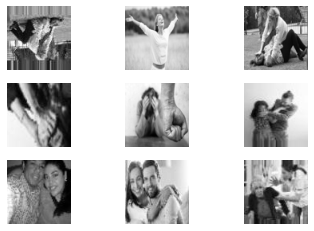

In [218]:
training_X = datasettrain_X
trainingLabels = datasettrain_Y
K = 2
N, d = np.shape(training_X)
training_R = np.zeros((N, K))
training_X = np.concatenate((np.ones((N, 1)), training_X), axis = 1)

for ixk in range(K):
    training_R[trainingLabels == ixk, ixk] = 1

fig = plt.figure()

for iimg in range(9):
    ax = fig.add_subplot(3, 3, (iimg + 1))
    plt.imshow(training_X[iimg, 1:].reshape((80,80)), cmap='gray')
    plt.axis("off")
    
plt.show()


In [ ]:
import time

H=100
regpar=1e-3
start = time.time()
V,W = training(training_X, training_R, H,regpar, 1e-3, 4e3, 1e-3)
end = time.time()

print("Training time: ", end - start, " seconds")
training_Y = activationFunction(training_X, V, W)
training_P = np.zeros(N)

for ix in range(N):
    training_P[ix] = np.argmax(training_Y[ix, :])
                                 
print("Training accuracy ", np.mean(training_P == trainingLabels) * 100, "%")

test_X = datasettest_X
testLabels = datasettest_Y
test_N, d = np.shape(test_X)
test_X = np.concatenate((np.ones((test_N, 1)), test_X), axis = 1)
test_Y = activationFunction(test_X[:, :], V, W)
test_P = np.zeros(test_N)

for ix in range(test_N):
    test_P[ix] = np.argmax(test_Y[ix, :])
                                 
print("Test accuracy ", np.mean(test_P == testLabels) * 100, "%") 

In [213]:
np.savetxt('W', np.matrix(W),fmt='%s')
np.savetxt('V', np.matrix(V),fmt='%s')

Imagen No violenta
predict  0  Precision de la predicion:  88.34 %


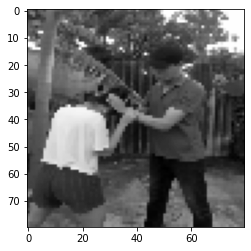

In [221]:
###########################################################################################
#######################     Predecir   ###################################################
##########################################################################################
imageNew = []
src = cv2.imread("./imagenesnuevas2/2.png", cv2.IMREAD_GRAYSCALE)
src = cv2.medianBlur(src,9)
src = cv2.resize(src, (80,80))
src = src/255.
arr = np.array(src)
imageNew.append(arr.ravel())
val_N,d = np.shape(imageNew)
val_X = np.concatenate((np.ones((val_N, 1)), imageNew), axis = 1)
predict = activationFunction(val_X[:,:], V, W)

#np.matrix(arr[0]).shape
plt.imshow(np.asarray(np.matrix(imageNew[0])).reshape(80,80),cmap="gray")

if(np.argmax(predict)==0):
    print("Imagen No violenta")
else:
    print("Imagen violenta")

Precision = "{0:.2f}".format(max(predict[0])*100)    
print("predict ",np.argmax(predict)," Precision de la predicion: ",Precision,"%")